In [1]:
import io
import os
from zipfile import ZipFile

import numpy as np
import pandas as pd
import librosa as lr
from tqdm import tqdm

os.listdir("../input")

['train_noisy.csv',
 'test',
 'train_curated',
 'train_noisy',
 'sample_submission.csv',
 'train_curated.csv']

In [2]:
df = pd.read_csv('../input/train_curated.csv', index_col='fname')
df.index = df.index.str.replace('.wav', '.npy')
binary_indicators = df.labels.str.get_dummies(',')
binary_indicators.head()

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,Gurgling,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
fname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006ae4e.npy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0019ef41.npy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
001ec0ad.npy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0026c7cb.npy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0026f116.npy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(256, 256)

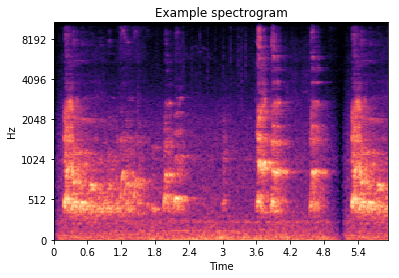

In [20]:
from librosa.display import specshow


def preprocess(wavfile):

    # Load roughly 8 seconds of audio.
    samples = 512*256 - 1
    samplerate = 16000
    waveform = lr.load(wavfile, samplerate, duration=samples/samplerate)[0]

    # Loop too short audio clips.
    if len(waveform) < samples:
        waveform = np.pad(waveform, (0, samples - len(waveform)), mode='wrap')

    # Convert audio to log-mel spectrogram.
    spectrogram = lr.feature.melspectrogram(waveform, samplerate, n_mels=256)
    spectrogram = lr.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)

    return spectrogram


sample = df.sample()
spectrogram = preprocess('../input/train_curated/0006ae4e.wav')
ax = specshow(spectrogram, y_axis='mel', x_axis='time')
ax.set_title('Example spectrogram')
spectrogram.shape

In [ ]:
with ZipFile('dataset.zip', 'w') as z:

    with io.StringIO() as f:
        binary_indicators.to_csv(f)
        z.writestr('index.csv', f.getvalue())

    d = '../input/train_curated'
    for n in tqdm(os.listdir(d), desc='Zipping spectrograms'):
        wavfile = os.path.join(d, n)
        spectrogram = preprocess(wavfile)
        with io.BytesIO() as f:
            np.save(f, spectrogram)
            z.writestr(n.replace('.wav', '.npy'), f.getvalue())